In [ ]:
!pip install datasets
!pip install transformers
!pip install numpy
!pip install torch
!pip install matplotlib
!pip install seaborn
!pip install pandas

In [ ]:
import datasets
from datasets import Dataset, DatasetDict
from transformers import AutoModelForCausalLM, AutoTokenizer

import numpy as np
import torch
import matplotlib.pyplot as plt
import gc
import random
import seaborn as sns
import pandas as pd

CACHE_DIR = "./cache"

In [ ]:
## DATASET CODE ##
def load_mnli_datasets() -> DatasetDict:
    print("\nLoading MNLI Dataset")
    mnli: DatasetDict = datasets.load_dataset("glue", "mnli", cache_dir=CACHE_DIR)  # type: ignore
    # Filter neutral examples for binary classification
    mnli = mnli.filter(lambda x: x["label"] != 1)

    # MNLI entailment is 0, contradiction is 2; update labels so that entailment is 1 and contradiction is 0
    def change_label(example):
        if example["label"] == 0:
            example["label"] = 1
        else:
            example["label"] = 0
        return example

    mnli = mnli.map(change_label)
    del mnli["test_matched"]
    del mnli["test_mismatched"]
    del mnli["validation_mismatched"]

    print("MNLI Datasets:")
    print(mnli)

    return mnli


def load_hans_dataset() -> Dataset:
    hans: Dataset = datasets.load_dataset("hans", cache_dir=CACHE_DIR, split="validation", trust_remote_code=True)  # type: ignore

    # HANS comes without indices, so we add them
    indices = list(range(len(hans)))
    hans = hans.add_column(name="idx", column=indices)

    # Filter for lexical overlap
    hans = hans.filter(lambda x: x["heuristic"] == "lexical_overlap")

    hans = hans.select_columns(["premise", "hypothesis", "label", "idx"])

    print("HANS Dataset:")
    print(hans)

    return hans

In [ ]:
## IN-CONTEXT LEARNING CODE ##
def create_few_shot_context(train_examples, context_indices):
    context = ""
    for idx in context_indices:
        example = train_examples[int(idx)]
        label_text = "True" if example["label"] == 1 else "False"
        context += f"{example['premise']}\nQuestion: {example['hypothesis']} True or False?\nAnswer: {label_text}\n\n"

    return context

In [ ]:
## CONTEXT DISTILLATION CODE ##
def compute_kl_divergence(teacher_logits, student_logits):
    teacher_probs = torch.softmax(teacher_logits, dim=-1)
    student_probs = torch.softmax(student_logits, dim=-1)
    return torch.nn.functional.kl_div(
        torch.log(student_probs),
        teacher_probs,
        reduction="batchmean",
        log_target=False
    )

def compute_cross_entropy(student_logits, labels, tokenizer):
    target_tokens = [" False", " True"]
    target_token_ids = [
        tokenizer.encode(token, add_special_tokens=False)[0] for token in target_tokens
    ]
    target_logits = student_logits[:, target_token_ids]
    ce_loss = torch.nn.functional.cross_entropy(target_logits, labels)
    return ce_loss


def get_teacher_logits(
    teacher_model, tokenizer, train_dataset, context, example_indices
):
    device = teacher_model.device
    all_teacher_logits = []

    for idx in example_indices:
        example = train_dataset[int(idx)]
        teacher_prompt = (
            context
            + f"{example['premise']}\nQuestion: {example['hypothesis']} True or False?\nAnswer:"
        )

        teacher_inputs = tokenizer(teacher_prompt, return_tensors="pt", padding=True)
        teacher_inputs = {k: v.to(device) for k, v in teacher_inputs.items()}

        with torch.no_grad():
            teacher_outputs = teacher_model(**teacher_inputs)
            teacher_logits = teacher_outputs.logits[0, -1]

        all_teacher_logits.append(teacher_logits.detach().clone())

    return all_teacher_logits


def train_student_model(
    student_model,
    tokenizer,
    train_dataset,
    example_indices,
    teacher_logits_list,
    num_epochs,
    learning_rate,
):
    device = student_model.device
    optimizer = torch.optim.Adam(student_model.parameters(), lr=learning_rate)

    # Add learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=2,
    )

    # Add gradient clipping
    max_grad_norm = 1.0

    print("Training student model...")
    for epoch in range(num_epochs):
        total_loss = 0

        student_model.train()
        for _, (idx, teacher_logits) in enumerate(
            zip(example_indices, teacher_logits_list)
        ):
            optimizer.zero_grad()

            example = train_dataset[int(idx)]
            student_prompt = f"{example['premise']}\nQuestion: {example['hypothesis']} True or False?\nAnswer:"

            student_inputs = tokenizer(
                student_prompt, return_tensors="pt", padding=True
            )
            student_inputs = {k: v.to(device) for k, v in student_inputs.items()}
            student_outputs = student_model(**student_inputs)
            student_logits = student_outputs.logits[:, -1, :]

            kl_loss = compute_kl_divergence(teacher_logits, student_logits)
            ce_loss = compute_cross_entropy(student_logits, torch.tensor([example['label']], device=device), tokenizer)
            loss = 0.5 * kl_loss + 0.5 * ce_loss

            loss.backward()

            torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_grad_norm)

            optimizer.step()

            del student_outputs, student_inputs, student_logits
            torch.cuda.empty_cache()
            # torch.mps.empty_cache()
            gc.collect()

            total_loss += loss.item()

        avg_loss = total_loss / len(example_indices)
        print(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

        scheduler.step(avg_loss)

In [ ]:
## EVALUATION CODE ##
def evaluate_icl(model, tokenizer, eval_dataset, context, eval_indices):
    device = model.device
    correct = 0
    total = 0
    labels = []
    target_tokens = [" False", " True"]
    target_token_ids = [
        tokenizer.encode(token, add_special_tokens=False)[0] for token in target_tokens
    ]

    for idx in eval_indices:
        example = eval_dataset[int(idx)]
        prompt = (
            context
            + f"{example['premise']}\nQuestion: {example['hypothesis']} True or False?\nAnswer:"
        )

        inputs = tokenizer(prompt, return_tensors="pt", padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits[0, -1]

        target_probs = logits[target_token_ids]
        predicted_label = torch.argmax(target_probs).item()

        if predicted_label == example["label"]:
            correct += 1
        labels.append(predicted_label)
        total += 1
    label, counts = np.unique(np.array(labels), return_counts=True)
    print(f"Prediction distribution:\tLabels: {label}, Count: {counts}")
    accuracy = correct / total
    return accuracy


def evaluate_cd(model, tokenizer, eval_dataset, eval_indices):
    device = model.device
    correct = 0
    total = 0
    labels = []
    target_tokens = [" False", " True"]
    target_token_ids = [
        tokenizer.encode(token, add_special_tokens=False)[0] for token in target_tokens
    ]

    for idx in eval_indices:
        example = eval_dataset[int(idx)]
        prompt = f"{example['premise']}\nQuestion: {example['hypothesis']} True or False?\nAnswer:"

        inputs = tokenizer(prompt, return_tensors="pt", padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits[0, -1]

        target_probs = logits[target_token_ids]
        predicted_label = torch.argmax(target_probs).item()
        labels.append(predicted_label)
        if predicted_label == example["label"]:
            correct += 1
        total += 1
    label, counts = np.unique(np.array(labels), return_counts=True)
    print(f"Prediction distribution:\tLabels: {label}, Count: {counts}")
    accuracy = correct / total
    return accuracy

In [ ]:
def eval(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

    models = [
        "facebook/opt-125m",
        "facebook/opt-350m",
        "facebook/opt-1.3b",
    ]

    if torch.backends.mps.is_available():
        device = torch.device("mps")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    print(f"Using device: {device}")

    mnli = load_mnli_datasets()
    training = mnli["train"]
    validation_in_domain = mnli["validation_matched"]
    validation_out_domain = load_hans_dataset()

    # ICL parameters
    num_shots = 10
    # Context distillation parameters
    num_train_examples = 20
    num_epochs = 10
    learning_rate = 1e-6
    # Validation parameters
    num_validation_samples = 100

    context_indices = np.random.choice(
        len(training), size=num_shots, replace=False
    )
    validation_in_domain_indices = np.random.choice(
        len(validation_in_domain), num_validation_samples, replace=False
    )
    validation_out_domain_indices = np.random.choice(
        len(validation_out_domain), num_validation_samples, replace=False
    )
    # Avoid using the same examples for the context and context distillation training
    available_indices = np.array(
        [i for i in range(len(training)) if i not in context_indices]
    )
    train_indices = np.random.choice(
        available_indices, size=num_train_examples, replace=False
    )

    indomain_label, indomain_count = np.unique(np.array(validation_in_domain[validation_in_domain_indices]['label']), return_counts=True)
    print(f"In-Domain Label Distribution:\tLabel: {indomain_label}, Count: {indomain_count}")

    outdomain_label, outdomain_count = np.unique(np.array(validation_out_domain[validation_out_domain_indices]['label']), return_counts=True)
    print(f"Out-Domain Label Distribution:\tLabel: {outdomain_label}, Count: {outdomain_count}")

    context = create_few_shot_context(training, context_indices=context_indices)

    results = {}

    for model_name in models:
        print(f"\nEvaluating {model_name}")

        teacher_model = AutoModelForCausalLM.from_pretrained(model_name)
        teacher_model = teacher_model.to(device)
        tokenizer = AutoTokenizer.from_pretrained(model_name)

        print("\nIn-Context Learning Evaluation:")
        icl_in_domain = evaluate_icl(
            model=teacher_model,
            tokenizer=tokenizer,
            eval_dataset=validation_in_domain,
            context=context,
            eval_indices=validation_in_domain_indices,
        )
        icl_out_domain = evaluate_icl(
            model=teacher_model,
            tokenizer=tokenizer,
            eval_dataset=validation_out_domain,
            context=context,
            eval_indices=validation_out_domain_indices,
        )
        print(f"ICL In-Domain: {icl_in_domain}")
        print(f"ICL Out-Domain: {icl_out_domain}")

        print("\nTraining student model with Context Distillation:")
        # Get teacher logits before training student
        print("Computing teacher logits...")
        teacher_logits_list = get_teacher_logits(
            teacher_model, tokenizer, training, context, train_indices
        )

        teacher_model = teacher_model.cpu()
        del teacher_model
        torch.cuda.empty_cache()
        # torch.mps.empty_cache()
        gc.collect()

        student_model = AutoModelForCausalLM.from_pretrained(model_name)
        student_model = student_model.to(device)

        train_student_model(
            student_model=student_model,
            tokenizer=tokenizer,
            train_dataset=training,
            example_indices=train_indices,
            teacher_logits_list=teacher_logits_list,
            num_epochs=num_epochs,
            learning_rate=learning_rate,
        )

        print("\nContext Distillation Evaluation:")
        cd_in_domain = evaluate_cd(
            model=student_model,
            tokenizer=tokenizer,
            eval_dataset=validation_in_domain,
            eval_indices=validation_in_domain_indices,
        )

        cd_out_domain = evaluate_cd(
            model=student_model,
            tokenizer=tokenizer,
            eval_dataset=validation_out_domain,
            eval_indices=validation_out_domain_indices,
        )
        print(f"CD In-Domain: {cd_in_domain}")
        print(f"CD Out-Domain: {cd_out_domain}")

        simple_model_name = model_name.split("/")[-1]
        results[simple_model_name] = {
            "icl_in_domain": icl_in_domain,
            "icl_out_domain": icl_out_domain,
            "cd_in_domain": cd_in_domain,
            "cd_out_domain": cd_out_domain,
        }

        student_model = student_model.cpu()
        del student_model
        torch.cuda.empty_cache()
        # torch.mps.empty_cache()
        gc.collect()

    return results

In [ ]:
all_results = {}

seed = 100
num_runs = 5
for run in range(seed, seed + num_runs):
    print(f"\n=== Running iteration {run - seed + 1}/{num_runs} with seed {run} ===")
    run_results = eval(seed=run)

    for model, scores in run_results.items():
        if model not in all_results:
            all_results[model] = {
                "icl_in_domain": [],
                "icl_out_domain": [],
                "cd_in_domain": [],
                "cd_out_domain": [],
            }
        for metric, value in scores.items():
            all_results[model][metric].append(value)


=== Running iteration 1/5 with seed 100 ===
Using device: cuda

Loading MNLI Dataset
MNLI Datasets:
DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 261802
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 6692
    })
})
HANS Dataset:
Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx'],
    num_rows: 10000
})
In-Domain Label Distribution:	Label: [0 1], Count: [55 45]
Out-Domain Label Distribution:	Label: [0 1], Count: [53 47]

Evaluating facebook/opt-125m

In-Context Learning Evaluation:
Prediction distribution:	Labels: [0 1], Count: [86 14]
Prediction distribution:	Labels: [0 1], Count: [96  4]
ICL In-Domain: 0.53
ICL Out-Domain: 0.53

Training student model with Context Distillation:
Computing teacher logits...
Training student model...
Epoch 1/10, Average Loss: 0.6944
Epoch 2/10, Average Loss: 0.3728
Epoch 3/10, Average Loss: 0.4051
Ep

config.json:   0%|          | 0.00/644 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/663M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]


In-Context Learning Evaluation:
Prediction distribution:	Labels: [0 1], Count: [30 70]
Prediction distribution:	Labels: [0 1], Count: [ 2 98]
ICL In-Domain: 0.57
ICL Out-Domain: 0.47

Training student model with Context Distillation:
Computing teacher logits...
Training student model...
Epoch 1/10, Average Loss: 0.5255
Epoch 2/10, Average Loss: 0.3854
Epoch 3/10, Average Loss: 0.2977
Epoch 4/10, Average Loss: 0.2886
Epoch 5/10, Average Loss: 0.2877
Epoch 6/10, Average Loss: 0.2400
Epoch 7/10, Average Loss: 0.2396
Epoch 8/10, Average Loss: 0.2764
Epoch 9/10, Average Loss: 0.2512
Epoch 10/10, Average Loss: 0.2550

Context Distillation Evaluation:
Prediction distribution:	Labels: [0 1], Count: [23 77]
Prediction distribution:	Labels: [0 1], Count: [11 89]
CD In-Domain: 0.46
CD Out-Domain: 0.4

Evaluating facebook/opt-1.3b


config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]


In-Context Learning Evaluation:
Prediction distribution:	Labels: [0 1], Count: [96  4]
Prediction distribution:	Labels: [0], Count: [100]
ICL In-Domain: 0.55
ICL Out-Domain: 0.53

Training student model with Context Distillation:
Computing teacher logits...
Training student model...
Epoch 1/10, Average Loss: 0.5511
Epoch 2/10, Average Loss: 0.3635
Epoch 3/10, Average Loss: 0.4223
Epoch 4/10, Average Loss: 0.3787
Epoch 5/10, Average Loss: 0.3800
Epoch 6/10, Average Loss: 0.3120
Epoch 7/10, Average Loss: 0.3120
Epoch 8/10, Average Loss: 0.2866
Epoch 9/10, Average Loss: 0.2895
Epoch 10/10, Average Loss: 0.2825

Context Distillation Evaluation:
Prediction distribution:	Labels: [0 1], Count: [61 39]
Prediction distribution:	Labels: [0 1], Count: [32 68]
CD In-Domain: 0.58
CD Out-Domain: 0.57

=== Running iteration 2/5 with seed 101 ===
Using device: cuda

Loading MNLI Dataset
MNLI Datasets:
DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
    

<ipython-input-25-07fec3fbd5ee>:24: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.barplot(


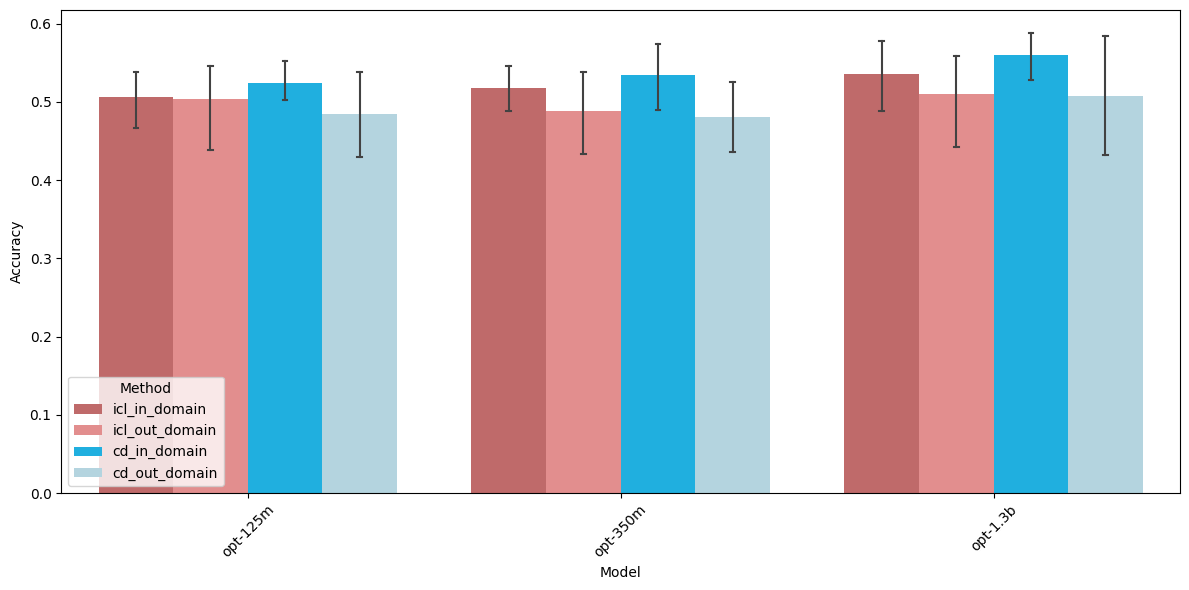

In [ ]:
plt.figure(figsize=(12, 6))

colors = {
    'icl_in_domain': 'indianred',
    'icl_out_domain': 'lightcoral',
    'cd_in_domain': 'deepskyblue',
    'cd_out_domain': 'lightblue'
}

models = list(all_results.keys())
metrics = ['icl_in_domain', 'icl_out_domain', 'cd_in_domain', 'cd_out_domain']

data = []
for model in models:
    for metric in metrics:
        data.extend([{
            'Model': model,
            'Method': metric,
            'Accuracy': value
        } for value in all_results[model][metric]])

df = pd.DataFrame(data)

sns.barplot(
    data=df,
    x='Model',
    y='Accuracy',
    hue='Method',
    palette=colors,
    capsize=0.05,
    errwidth=1.5
)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
for model_name, scores in all_results.items():
    print(f"\n{model_name}:")
    for metric, values in scores.items():
        mean = np.mean(values)
        std = np.std(values)
        print(f"  {metric}: {mean:.3f} ± {std:.3f}")


opt-125m:
  icl_in_domain: 0.506 ± 0.042
  icl_out_domain: 0.504 ± 0.064
  cd_in_domain: 0.524 ± 0.030
  cd_out_domain: 0.484 ± 0.064

opt-350m:
  icl_in_domain: 0.518 ± 0.035
  icl_out_domain: 0.488 ± 0.063
  cd_in_domain: 0.534 ± 0.047
  cd_out_domain: 0.480 ± 0.048

opt-1.3b:
  icl_in_domain: 0.536 ± 0.050
  icl_out_domain: 0.510 ± 0.068
  cd_in_domain: 0.560 ± 0.036
  cd_out_domain: 0.508 ± 0.093


In [ ]:
# Additional experiments with different KL:CE loss weight ratios

In [ ]:
# 3-1 kl-ce run
all_results = {}

seed = 100
num_runs = 5
for run in range(seed, seed + num_runs):
    print(f"\n=== Running iteration {run - seed + 1}/{num_runs} with seed {run} ===")
    run_results = eval(seed=run)

    for model, scores in run_results.items():
        if model not in all_results:
            all_results[model] = {
                "icl_in_domain": [],
                "icl_out_domain": [],
                "cd_in_domain": [],
                "cd_out_domain": [],
            }
        for metric, value in scores.items():
            all_results[model][metric].append(value)


=== Running iteration 1/5 with seed 100 ===
Using device: cuda

Loading MNLI Dataset
MNLI Datasets:
DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 261802
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 6692
    })
})
HANS Dataset:
Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx'],
    num_rows: 10000
})
In-Domain Label Distribution:	Label: [0 1], Count: [55 45]
Out-Domain Label Distribution:	Label: [0 1], Count: [53 47]

Evaluating facebook/opt-125m

In-Context Learning Evaluation:
Prediction distribution:	Labels: [0 1], Count: [86 14]
Prediction distribution:	Labels: [0 1], Count: [96  4]
ICL In-Domain: 0.53
ICL Out-Domain: 0.53

Training student model with Context Distillation:
Computing teacher logits...
Training student model...
Epoch 1/10, Average Loss: 0.6944
Epoch 2/10, Average Loss: 0.3728
Epoch 3/10, Average Loss: 0.4051
Ep

In [ ]:
# 2-1 kl-ce run
all_results = {}

seed = 100
num_runs = 5
for run in range(seed, seed + num_runs):
    print(f"\n=== Running iteration {run - seed + 1}/{num_runs} with seed {run} ===")
    run_results = eval(seed=run)

    for model, scores in run_results.items():
        if model not in all_results:
            all_results[model] = {
                "icl_in_domain": [],
                "icl_out_domain": [],
                "cd_in_domain": [],
                "cd_out_domain": [],
            }
        for metric, value in scores.items():
            all_results[model][metric].append(value)

In [ ]:
# 1-1 kl-ce run
all_results = {}

seed = 100
num_runs = 5
for run in range(seed, seed + num_runs):
    print(f"\n=== Running iteration {run - seed + 1}/{num_runs} with seed {run} ===")
    run_results = eval(seed=run)

    for model, scores in run_results.items():
        if model not in all_results:
            all_results[model] = {
                "icl_in_domain": [],
                "icl_out_domain": [],
                "cd_in_domain": [],
                "cd_out_domain": [],
            }
        for metric, value in scores.items():
            all_results[model][metric].append(value)

In [ ]:
# 1-2 kl-ce run
all_results = {}

seed = 100
num_runs = 5
for run in range(seed, seed + num_runs):
    print(f"\n=== Running iteration {run - seed + 1}/{num_runs} with seed {run} ===")
    run_results = eval(seed=run)

    for model, scores in run_results.items():
        if model not in all_results:
            all_results[model] = {
                "icl_in_domain": [],
                "icl_out_domain": [],
                "cd_in_domain": [],
                "cd_out_domain": [],
            }
        for metric, value in scores.items():
            all_results[model][metric].append(value)

In [ ]:
# 1-5 kl-ce run
all_results = {}

seed = 100
num_runs = 5
for run in range(seed, seed + num_runs):
    print(f"\n=== Running iteration {run - seed + 1}/{num_runs} with seed {run} ===")
    run_results = eval(seed=run)

    for model, scores in run_results.items():
        if model not in all_results:
            all_results[model] = {
                "icl_in_domain": [],
                "icl_out_domain": [],
                "cd_in_domain": [],
                "cd_out_domain": [],
            }
        for metric, value in scores.items():
            all_results[model][metric].append(value)

In [ ]:
# 1-1 kl-ce run 2
all_results = {}

seed = 100
num_runs = 5
for run in range(seed, seed + num_runs):
    print(f"\n=== Running iteration {run - seed + 1}/{num_runs} with seed {run} ===")
    run_results = eval(seed=run)

    for model, scores in run_results.items():
        if model not in all_results:
            all_results[model] = {
                "icl_in_domain": [],
                "icl_out_domain": [],
                "cd_in_domain": [],
                "cd_out_domain": [],
            }
        for metric, value in scores.items():
            all_results[model][metric].append(value)

In [ ]:
# 1-1 kl-ce run 3
all_results = {}

seed = 100
num_runs = 5
for run in range(seed, seed + num_runs):
    print(f"\n=== Running iteration {run - seed + 1}/{num_runs} with seed {run} ===")
    run_results = eval(seed=run)

    for model, scores in run_results.items():
        if model not in all_results:
            all_results[model] = {
                "icl_in_domain": [],
                "icl_out_domain": [],
                "cd_in_domain": [],
                "cd_out_domain": [],
            }
        for metric, value in scores.items():
            all_results[model][metric].append(value)

In [ ]:
plt.figure(figsize=(12, 6))

colors = {
    'icl_in_domain': 'indianred',
    'icl_out_domain': 'lightcoral',
    'cd_in_domain': 'deepskyblue',
    'cd_out_domain': 'lightblue'
}

models = list(all_results.keys())
metrics = ['icl_in_domain', 'icl_out_domain', 'cd_in_domain', 'cd_out_domain']

data = []
for model in models:
    for metric in metrics:
        data.extend([{
            'Model': model,
            'Method': metric,
            'Accuracy': value
        } for value in all_results[model][metric]])

df = pd.DataFrame(data)

sns.barplot(
    data=df,
    x='Model',
    y='Accuracy',
    hue='Method',
    palette=colors,
    capsize=0.05,
    errwidth=1.5
)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# 3-1 kl-ce
for model_name, scores in all_results.items():
    print(f"\n{model_name}:")
    for metric, values in scores.items():
        mean = np.mean(values)
        std = np.std(values)
        print(f"  {metric}: {mean:.3f} ± {std:.3f}")

In [ ]:
# 2-1 kl-ce
for model_name, scores in all_results.items():
    print(f"\n{model_name}:")
    for metric, values in scores.items():
        mean = np.mean(values)
        std = np.std(values)
        print(f"  {metric}: {mean:.3f} ± {std:.3f}")

In [ ]:
# 1-1 kl-ce 2
for model_name, scores in all_results.items():
    print(f"\n{model_name}:")
    for metric, values in scores.items():
        mean = np.mean(values)
        std = np.std(values)
        print(f"  {metric}: {mean:.3f} ± {std:.3f}")

In [ ]:
# 1-1 kl-ce
for model_name, scores in all_results.items():
    print(f"\n{model_name}:")
    for metric, values in scores.items():
        mean = np.mean(values)
        std = np.std(values)
        print(f"  {metric}: {mean:.3f} ± {std:.3f}")

In [ ]:
# 1-1 kl-ce 3
for model_name, scores in all_results.items():
    print(f"\n{model_name}:")
    for metric, values in scores.items():
        mean = np.mean(values)
        std = np.std(values)
        print(f"  {metric}: {mean:.3f} ± {std:.3f}")

In [ ]:
# 1-2 kl-ce
for model_name, scores in all_results.items():
    print(f"\n{model_name}:")
    for metric, values in scores.items():
        mean = np.mean(values)
        std = np.std(values)
        print(f"  {metric}: {mean:.3f} ± {std:.3f}")

In [ ]:
# 1-5 kl-ce
for model_name, scores in all_results.items():
    print(f"\n{model_name}:")
    for metric, values in scores.items():
        mean = np.mean(values)
        std = np.std(values)
        print(f"  {metric}: {mean:.3f} ± {std:.3f}")